# Multi-label Text Classification

src:
- https://github.com/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb
- https://medium.com/@lidores98/finetuning-huggingface-facebook-bart-model-2c758472e340
- https://github.com/huggingface/notebooks/blob/main/examples/text_classification.ipynb
- https://towardsdatascience.com/multi-label-emotion-classification-with-pytorch-huggingfaces-transformers-and-w-b-for-tracking-a060d817923
- https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/
- https://kyawkhaung.medium.com/multi-label-text-classification-with-bert-using-pytorch-47011a7313b9

In [3]:
!pip install -q transformers datasets
!pip install accelerate -U

In [4]:
from datasets import Dataset, load_metric
from transformers import AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
torch.cuda.empty_cache() if torch.cuda.is_available() else None

## Load dataset

In [7]:
df = pd.read_json('./dataset/18labels_train_set.json').transpose()
display(df.head(3))

,Title,Abstract,Classes
1,Activated carbon derived from bacterial cellul...,© 2019 Elsevier B.V.Activated carbon derived f...,"[CHE, MATENG]"
2,The algorithm of static hand gesture recogniti...,© Springer International Publishing AG 2018.Te...,[CPE]
3,Alternative Redundant Residue Number System Co...,© 2018 IEEE.Residue number system (RNS) is a n...,[EE]


In [8]:
data = df.reset_index(drop=True).copy()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     454 non-null    object
 1   Abstract  454 non-null    object
 2   Classes   454 non-null    object
dtypes: object(3)
memory usage: 10.8+ KB


## Prepare data

### Check null

In [10]:
data.isnull().sum() # check null

Title       0
Abstract    0
Classes     0
dtype: int64

### Check deplicate

In [11]:
# # check deplicate
# for i in data:
#   print(i, data.duplicated(subset=[f'{i}']).sum())

In [12]:
# data.drop_duplicates(subset=['Title'],inplace=True)
# # print(data.duplicated(subset=['Title']).sum()) # check deplicate

# data = data.reset_index(drop=True)

### Merge column

In [13]:
data['Abstract'] = data['Abstract'] + ' ' + data['Title']
data.drop(columns=['Title'], inplace=True)
display(data.head(3))

,Abstract,Classes
0,© 2019 Elsevier B.V.Activated carbon derived f...,"[CHE, MATENG]"
1,© Springer International Publishing AG 2018.Te...,[CPE]
2,© 2018 IEEE.Residue number system (RNS) is a n...,[EE]


### Define label

In [14]:
labels = [
    'CE',
    'ENV',
    'BME',
    'PE',
    'METAL',
    'ME',
    'EE',
    'CPE',
    'OPTIC',
    'NANO',
    'CHE',
    'MATENG',
    'AGRI',
    'EDU',
    'IE',
    'SAFETY',
    'MATH',
    'MATSCI'
]

full_labels_dict = {
    'CE': 'civil engineering',
    'ENV': 'environmental engineering',
    'BME': 'biomedical engineering',
    'PE': 'petroleum engineering',
    'METAL': 'metallurgical engineering',
    'ME': 'mechanical engineering',
    'EE': 'electrical engineering',
    'CPE': 'computer engineering',
    'OPTIC': 'optical engineering',
    'NANO': 'nano engineering',
    'CHE': 'chemical engineering',
    'MATENG': 'materials engineering',
    'AGRI': 'agricultural engineering',
    'EDU': 'education',
    'IE': 'industrial engineering',
    'SAFETY': 'safety engineering',
    'MATH': 'mathematics and statistics',
    'MATSCI': 'material science'
}

full_labels = [
    'civil engineering',
    'environmental engineering',
    'biomedical engineering',
    'petroleum engineering',
    'metallurgical engineering',
    'mechanical engineering',
    'electrical engineering',
    'computer engineering',
    'optical engineering',
    'nano engineering',
    'chemical engineering',
    'materials engineering',
    'agricultural engineering',
    'education',
    'industrial engineering',
    'safety engineering',
    'mathematics and statistics',
    'material science'
]

In [15]:
id2label = {idx:label for idx, label in enumerate(full_labels)}
label2id = {label:idx for idx, label in enumerate(full_labels)}
print(id2label)
print(label2id)

{0: 'civil engineering', 1: 'environmental engineering', 2: 'biomedical engineering', 3: 'petroleum engineering', 4: 'metallurgical engineering', 5: 'mechanical engineering', 6: 'electrical engineering', 7: 'computer engineering', 8: 'optical engineering', 9: 'nano engineering', 10: 'chemical engineering', 11: 'materials engineering', 12: 'agricultural engineering', 13: 'education', 14: 'industrial engineering', 15: 'safety engineering', 16: 'mathematics and statistics', 17: 'material science'}
{'civil engineering': 0, 'environmental engineering': 1, 'biomedical engineering': 2, 'petroleum engineering': 3, 'metallurgical engineering': 4, 'mechanical engineering': 5, 'electrical engineering': 6, 'computer engineering': 7, 'optical engineering': 8, 'nano engineering': 9, 'chemical engineering': 10, 'materials engineering': 11, 'agricultural engineering': 12, 'education': 13, 'industrial engineering': 14, 'safety engineering': 15, 'mathematics and statistics': 16, 'material science': 17}


In [16]:
for label in full_labels_dict:
    lable_list = []
    for i in data['Classes']:
        if label in i:
            lable_list.append(1.0)
        else:
            lable_list.append(0.0)
    data[full_labels_dict[label]] = lable_list

In [17]:
display(data.head(3))

,Abstract,Classes,civil engineering,environmental engineering,biomedical engineering,petroleum engineering,metallurgical engineering,mechanical engineering,electrical engineering,computer engineering,optical engineering,nano engineering,chemical engineering,materials engineering,agricultural engineering,education,industrial engineering,safety engineering,mathematics and statistics,material science
0,© 2019 Elsevier B.V.Activated carbon derived f...,"[CHE, MATENG]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,© Springer International Publishing AG 2018.Te...,[CPE],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,© 2018 IEEE.Residue number system (RNS) is a n...,[EE],0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
for i in full_labels:
  print(f'# of articles in {i}: {int(data[i].sum())} articles, {round(data[i].sum()/len(data),2)}%')

# of articles in civil engineering: 52 articles, 0.11%
# of articles in environmental engineering: 59 articles, 0.13%
# of articles in biomedical engineering: 36 articles, 0.08%
# of articles in petroleum engineering: 86 articles, 0.19%
# of articles in metallurgical engineering: 72 articles, 0.16%
# of articles in mechanical engineering: 90 articles, 0.2%
# of articles in electrical engineering: 118 articles, 0.26%
# of articles in computer engineering: 142 articles, 0.31%
# of articles in optical engineering: 31 articles, 0.07%
# of articles in nano engineering: 32 articles, 0.07%
# of articles in chemical engineering: 177 articles, 0.39%
# of articles in materials engineering: 64 articles, 0.14%
# of articles in agricultural engineering: 20 articles, 0.04%
# of articles in education: 32 articles, 0.07%
# of articles in industrial engineering: 74 articles, 0.16%
# of articles in safety engineering: 22 articles, 0.05%
# of articles in mathematics and statistics: 112 articles, 0.25%
# 


### Clean data

In [19]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('stopwords')
set_stopwords = set(stopwords.words('english'))
set_stopwords.update(['nan'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def text_clean(x):
    # Light
    x = x.lower() # lowercase everything
    x = x.encode('ascii', 'ignore').decode() # remove unicode characters
    x = re.sub(r'https*\S+', ' ', x) # remove links
    x = re.sub(r'http*\S+', ' ', x)
    # # cleaning up text
    x = re.sub(r'\'\w+', '', x)
    x = re.sub(r'\w*\d+\w*', '', x)
    x = re.sub(r'\s{2,}', ' ', x)
    x = re.sub(r'\s[^\w\s]\s', '', x)

    # Heavy
    # x = ' '.join([word for word in x.split(' ') if word not in set_stopwords])
    x = re.sub(r'@\S', '', x)
    x = re.sub(r'#\S+', ' ', x)
    x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
    # # remove single letters and numbers surrounded by space
    x = re.sub(r'\s[a-z]\s|\s[0-9]\s', ' ', x)

    return x

In [21]:
data['Abstract'] = data['Abstract'].apply(text_clean)
data

,Abstract,Classes,civil engineering,environmental engineering,biomedical engineering,petroleum engineering,metallurgical engineering,mechanical engineering,electrical engineering,computer engineering,optical engineering,nano engineering,chemical engineering,materials engineering,agricultural engineering,education,industrial engineering,safety engineering,mathematics and statistics,material science
0,elsevier v activated carbon derived from bact...,"[CHE, MATENG]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,springer international publishing ag technol...,[CPE],0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ieee residue number system rns is number re...,[EE],0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,published under licence by iop publishing ltd...,"[PE, ME, CHE]",0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,john wileysons ltd the undrained bearing cap...,"[CE, MATSCI]",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,ieeethis paper presents portable and inexpens...,"[CPE, CHE]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
450,copyright for this paper by its authors use p...,"[CPE, EDU]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
451,the authors and ios press all rights reserve...,"[ENV, EE, CHE]",0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
452,ieee semantic segmentation is fundamental tas...,"[EE, CPE, OPTIC, EDU]",0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Split data

In [22]:
data_test, data_train = train_test_split(data, test_size=0.95, random_state=13)
display(data_train.shape)
display(data_test.shape)

(432, 20)

(22, 20)

In [23]:
data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

## Preprocess data

In [24]:
data_train_set = Dataset.from_pandas(data_train)
data_test_set = Dataset.from_pandas(data_test)
print(data_train_set)
print(data_test_set)

Dataset({
    features: ['Abstract', 'Classes', 'civil engineering', 'environmental engineering', 'biomedical engineering', 'petroleum engineering', 'metallurgical engineering', 'mechanical engineering', 'electrical engineering', 'computer engineering', 'optical engineering', 'nano engineering', 'chemical engineering', 'materials engineering', 'agricultural engineering', 'education', 'industrial engineering', 'safety engineering', 'mathematics and statistics', 'material science'],
    num_rows: 432
})
Dataset({
    features: ['Abstract', 'Classes', 'civil engineering', 'environmental engineering', 'biomedical engineering', 'petroleum engineering', 'metallurgical engineering', 'mechanical engineering', 'electrical engineering', 'computer engineering', 'optical engineering', 'nano engineering', 'chemical engineering', 'materials engineering', 'agricultural engineering', 'education', 'industrial engineering', 'safety engineering', 'mathematics and statistics', 'material science'],
    num

In [25]:
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [26]:
def preprocess_data(examples):
    abstract = examples['Abstract']
    # encode them
    encoding = tokenizer(abstract, padding='max_length', truncation=True, max_length=512)
    # add labels
    labels_batch = {k: examples[k] for k in examples.keys() if k in full_labels}
    # create numpy array of shape (batch_size, num_labels)
    labels_matrix = np.zeros((len(abstract), len(full_labels)))
    # fill numpy array
    for idx, label in enumerate(full_labels):
        labels_matrix[:, idx] = labels_batch[label]

    encoding['labels'] = labels_matrix.tolist()

    return encoding

In [27]:
encoded_dataset = data_train_set.map(preprocess_data, batched=True, remove_columns=data_train_set.column_names)
encoded_test_set = data_test_set.map(preprocess_data, batched=True, remove_columns=data_test_set.column_names)

Map:   0%|          | 0/432 [00:00<?, ? examples/s]

Map:   0%|          | 0/22 [00:00<?, ? examples/s]

In [28]:
example = encoded_dataset[0]
print(example.keys())
print(tokenizer.decode(example['input_ids']))
print(example['labels'])
print([id2label[idx] for idx, label in enumerate(example['labels']) if label == 1.0])

dict_keys(['input_ids', 'attention_mask', 'labels'])
<s> by the authors in the remote sensing domain  it is crucial to complete semantic segmentation on the raster images  g   river  building  forest  etc   on raster images  deep convolutional encoder decoder  dced  network is the state of the art semantic segmentation method for remotely sensed images  however  the accuracy is still limited  since the network is not designed for remotely sensed images and the training data in this domain is deficient  in this paper  we aim to propose novel cnn for semantic segmentation particularly for remote sensing corpora with three main contributions  first  we propose applying recent cnn called global convolutional network  gcn   since it can capture different resolutions by extracting multi scale features from different stages of the network  additionally  we further enhance the network by improving its backbone using larger numbers of layers  which is suitable for medium resolution remotely sen

In [29]:
encoded_dataset.set_format('torch')
encoded_test_set.set_format('torch')

### Check Max sentence length

In [30]:
token_counts = []
abstract = data_train_set['Abstract']
for row in range(len(data_train_set)):
    token_count = len(tokenizer.encode(
        abstract[row],
        max_length=512,
        truncation=True
    ))
    token_counts.append(token_count)

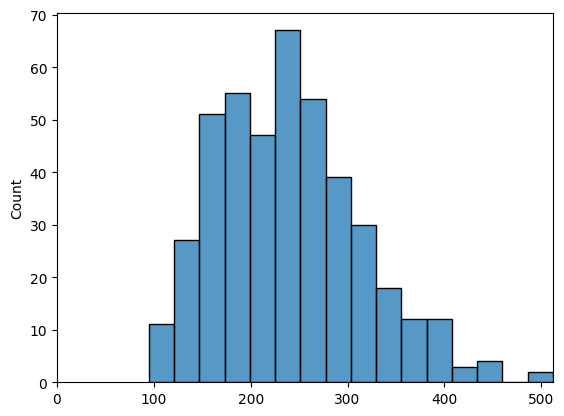

In [31]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

## Model

In [32]:
batch_size = 4
metric_name = 'f1'
num_epochs = 10
steps_per_epoch = len(data_train_set) // batch_size
total_training_steps = steps_per_epoch * num_epochs
warmup_steps = total_training_steps // 5
print(warmup_steps, total_training_steps)

216 1080


In [33]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.18):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    # try:
    #     roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    # except ValueError:
    #     pass
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {
        'f1': f1_micro_average,
        'roc_auc': roc_auc,
        'accuracy': accuracy
    }
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(
            p.predictions,
            tuple
        ) else p.predictions
    result = multi_label_metrics(
            predictions=preds,
            labels=p.label_ids
        )
    return result

### Bart model

In [34]:
model = AutoModelForSequenceClassification.from_pretrained(
    'facebook/bart-large-mnli',
    problem_type='multi_label_classification',
    num_labels=len(full_labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model = model.to(device)

args = TrainingArguments(
    'bart-finetuned',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    warmup_steps=warmup_steps
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset,
    eval_dataset=encoded_test_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-large-mnli and are newly initialized because the shapes did not match:
- classification_head.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([18]) in the model instantiated
- classification_head.out_proj.weight: found shape torch.Size([3, 1024]) in the checkpoint and torch.Size([18, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
model

BartForSequenceClassification(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): Layer

In [36]:
print(encoded_dataset[0]['labels'].type())
print(encoded_dataset['input_ids'][0])
#forward pass
outputs = model(input_ids=encoded_dataset['input_ids'][0].unsqueeze(0).to(device), labels=encoded_dataset[0]['labels'].unsqueeze(0).to(device))
print(outputs)

torch.FloatTensor
tensor([    0,    30,     5,  7601,    11,     5,  6063, 29720, 11170,  1437,
           24,    16,  4096,     7,  1498, 46195,  2835,  1258,    15,     5,
          910,  8831,  3156,  1437,   821,  1437,  1437,  4908,  1437,   745,
         1437,  6693,  1437,  4753,  1437,  1437,    15,   910,  8831,  3156,
         1437,  1844, 15380, 23794,   337,  9689, 15362,  5044, 15362,  1437,
          385,  7618,  1437,  1546,    16,     5,   194,     9,     5,  1808,
        46195,  2835,  1258,  5448,    13, 18684, 37667,  3156,  1437,   959,
         1437,     5,  8611,    16,   202,  1804,  1437,   187,     5,  1546,
           16,    45,  1887,    13, 18684, 37667,  3156,     8,     5,  1058,
          414,    11,    42, 11170,    16, 38396,  1437,    11,    42,  2225,
         1437,    52,  4374,     7, 15393,  5808,   740, 15688,    13, 46195,
         2835,  1258,  1605,    13,  6063, 29720, 22997,   102,    19,   130,
         1049,  5694,  1437,    78,  1437,    

In [37]:
trainer.train()

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.383813,0.370044,0.650150,0.000000
2,No log,0.330461,0.511905,0.748177,0.000000
3,No log,0.319538,0.526882,0.777778,0.000000
4,No log,0.301788,0.548780,0.773059,0.000000
5,0.330800,0.274604,0.566265,0.788932,0.045455
6,0.330800,0.289237,0.564706,0.792364,0.045455
7,0.330800,0.274564,0.610390,0.806950,0.045455
8,0.330800,0.281606,0.581560,0.769841,0.045455
9,0.330800,0.283488,0.583333,0.774775,0.045455
10,0.138000,0.279889,0.575342,0.771772,0.045455


TrainOutput(global_step=1080, training_loss=0.22412561884632817, metrics={'train_runtime': 1987.5917, 'train_samples_per_second': 2.173, 'train_steps_per_second': 0.543, 'total_flos': 4695120074833920.0, 'train_loss': 0.22412561884632817, 'epoch': 10.0})

In [38]:
trainer.evaluate()

{'eval_loss': 0.27456387877464294,
 'eval_f1': 0.6103896103896105,
 'eval_roc_auc': 0.806949806949807,
 'eval_accuracy': 0.045454545454545456,
 'eval_runtime': 2.8757,
 'eval_samples_per_second': 7.65,
 'eval_steps_per_second': 2.086,
 'epoch': 10.0}

# Optimize threshold

In [49]:
threshold = [i/1000 for i in range(170,200)]
# threshold = [i/100 for i in range(15,50)]
threshold_dict = {}
for t in threshold:
  result = []
  for text in data_test['Abstract']:
  # for text in cleaned_data['Abstract']:
      encoding = tokenizer(text, return_tensors='pt')
      # encoding = tokenizer(data['Abstract'][i], data['Title'][i], return_tensors='pt')
      encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

      outputs = trainer.model(**encoding)

      logits = outputs.logits
      logits.shape

      # apply sigmoid + threshold
      sigmoid = torch.nn.Sigmoid()
      probs = sigmoid(logits.squeeze().cpu())
      predictions = np.zeros(probs.shape)
      predictions[np.where(probs >= t)] = 1.0
      result.append(predictions)

  pred_labels = []
  for label in labels:
      pred_labels.append(f'pred_{label}')
  output = pd.concat([data_test[full_labels], pd.DataFrame(result, columns=pred_labels)], axis=1)

  y_pred = output[pred_labels]
  y_true = output[full_labels]
  f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
  # roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
  # accuracy = accuracy_score(y_true, y_pred)
  # print('f1', f1_micro_average)
  # print('auc', roc_auc)
  # print('acc', accuracy)
  threshold_dict[t] = f1_micro_average
best_threshold = list(filter(lambda x: threshold_dict[x] == max(threshold_dict.values()), threshold_dict))
print('Best Threshold at ', best_threshold, 'F1: ', threshold_dict[best_threshold[0]])

Best Threshold at  [0.179, 0.18] F1:  0.6103896103896105


# Predict labels on test set

In [41]:
df_test = pd.read_json('./dataset/18labels_test_set.json').transpose()
display(df_test.head(3))

,Title,Abstract
001eval,Comparative Electrical Energy Yield Performanc...,© 2013 IEEE.Long-term energy evaluation of PV ...
002eval,Effects of graphene nanoplatelets on bio-based...,© The Author(s) 2021.Novel near-infrared (NIR)...
003eval,Anti-inflammatory action of two novel peptides...,© The Royal Society of Chemistry 2020.Peanut w...


In [42]:
df_test['id'] = df_test.index
df_test = df_test.reset_index(drop=True)

In [43]:
df_test['Abstract'] = df_test['Abstract'] + ' ' + df_test['Title']
df_test.drop(columns=['Title'], inplace=True)

In [44]:
df_test['Abstract'] = df_test['Abstract'].apply(text_clean)

In [45]:
result = []
for text in df_test['Abstract']:
# for text in cleaned_data['Abstract']:
    encoding = tokenizer(text, return_tensors='pt')
    # encoding = tokenizer(df_test['Abstract'][i], df_test['Title'][i], return_tensors='pt')
    encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

    outputs = trainer.model(**encoding)

    logits = outputs.logits
    logits.shape

    # apply sigmoid + threshold
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits.squeeze().cpu())
    predictions = np.zeros(probs.shape)
    predictions[np.where(probs >= 0.18)] = 1
    result.append(predictions)

final_output = pd.concat([df_test['id'], pd.DataFrame(result, columns=labels)], axis=1)
final_output.to_csv('./output/18labels_result.csv', index=False)

In [46]:
final_output

,id,CE,ENV,BME,PE,METAL,ME,EE,CPE,OPTIC,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI
0,001eval,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,002eval,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,003eval,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,004eval,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,005eval,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,147eval,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
147,148eval,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,149eval,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149,150eval,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Save model

In [47]:
trainer.save_model('./model') # save model
tokenizer.save_pretrained('./model') # save tokenizer

('/content/drive/MyDrive/Colab Notebooks/multilabel_text_classification/model/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/multilabel_text_classification/model/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/multilabel_text_classification/model/vocab.json',
 '/content/drive/MyDrive/Colab Notebooks/multilabel_text_classification/model/merges.txt',
 '/content/drive/MyDrive/Colab Notebooks/multilabel_text_classification/model/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/multilabel_text_classification/model/tokenizer.json')